In [124]:
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import random

from os import listdir
from os.path import isfile, join
import pickle
import time

plt.style.use('seaborn-white')

%matplotlib inline

from scipy.stats import gamma, poisson

import epyestim
import epyestim.covid19 as covid19
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from xgboost import XGBRegressor, DMatrix, train
from sklearn.multioutput import MultiOutputRegressor

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pykalman import KalmanFilter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping

import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from functools import partial
import copy

data_path = "/Users/filipkrasniqi/Documents/Datasets.tmp/traffic-covid/"

saved = "{}saved/".format(data_path)
predictions_path = '{}predictions/'.format(saved)
test_path, train_path = '{}test.csv'.format(predictions_path), '{}train.csv'.format(predictions_path)

models = {}

max_lag = 28
lags_target = range(1, max_lag)

model_name, region = 'Poly3', 'Lombardia'

def train_in_interval(interval):
    df_ts = df_train.copy()
    df_ts = df_ts.loc[(df_ts.index>=interval[0])&(df_ts.index < interval[1])]
    
    for lag in lags_target:
        target = "target_{}".format(lag)
        df_ts_lag = df_ts.copy().drop(columns=[col for col in targets if (col not in features) and (col != target)]).dropna()
        
        test_dates = df_ts_lag.index
        print("{} for {} with lag = {}: {} -> {}, {}".format(model_name, region, lag, min(test_dates), max(test_dates), df_ts_lag.shape))
        
        model = make_pipeline(PolynomialFeatures(3), Ridge())

        model.fit(df_ts_lag[features], df_ts_lag[target])
        models[lag] = model
    return models



In [138]:
df_train, df_test = pd.read_csv(train_path), pd.read_csv(test_path)

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_train.set_index('Date', inplace=True)
df_test.set_index('Date', inplace=True)

targets = [t for t in df_train.columns if "target" in t]
features = [t for t in df_train.columns if "target" not in t]

T_f = 14
features = [f for f in features if not f.split("_")[-1].isdigit() or int(f.split("_")[-1]) <= T_f]

In [139]:
start_train_po, end_train_so = pd.to_datetime('2020-03-01'), pd.to_datetime('2020-10-25')
models = train_in_interval((start_train_po, end_train_so))

Poly3 for Lombardia with lag = 1: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 2: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 3: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 4: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 5: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 6: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 7: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 8: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 9: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 10: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag = 11: 2020-03-27 00:00:00 -> 2020-07-01 00:00:00, (97, 111)
Poly3 for Lombardia with lag =

In [140]:
window_train = 60

def test_in_interval(interval):
    df_results = pd.DataFrame()
    results_dict = []
    
    df_ts = df_test.loc[(df_test.index>=interval[0])&(df_test.index < interval[1])]
    
    for idx_lag, lag in enumerate(lags_target):
        target_col = targets[idx_lag]
        current_df_ts = df_ts[features+[target_col]].copy().dropna()
        test_dates = current_df_ts.index
        
        print("{} for {} with lag = {}: {} -> {}, {}".format(model_name, region, lag, min(test_dates), max(test_dates), current_df_ts.shape))
        for i, t in enumerate(test_dates):
            current_samples = df_ts.loc[t:t]
            current_features = current_samples[features]
            
            temp_walk_forward_df = pd.concat([df_train, df_test])
            temp_walk_forward_df = temp_walk_forward_df.loc[:t]
            walk_forward_df = temp_walk_forward_df.iloc[-1*window_train:]
            
            #print(" ===> t: [{} -> {}] => {}, #samples= {}".format(min(walk_forward_df.index), max(walk_forward_df.index), t + datetime.timedelta(days=lag), walk_forward_df.shape))

            predictions = models[lag].predict(current_features)

            X_test_fit, y_test_fit = current_features, current_samples[target_col].values
            current_result = {"model": model_name,"date": t, "lag": lag, "region": region, "prediction": predictions[0], "target": y_test_fit[0]}
            results_dict.append(current_result)
            
            features_vals, targets_vals = walk_forward_df[features], walk_forward_df[target_col]
            
            models[lag] = make_pipeline(PolynomialFeatures(3), Ridge())
            models[lag].fit(features_vals, targets_vals)

    df_results = pd.DataFrame(results_dict)
    df_results = df_results.dropna()
    df_results.set_index(['model', 'date', 'region', 'lag'], inplace=True)
    df_results['error']=(df_results['prediction']-df_results['target']).abs()
    df_results['error_2'] = df_results['error']**2
    return models, df_results

min_date, max_date = df_test.index.get_level_values(0).min(), df_test.index.get_level_values(0).max()
models_regions, df_results = test_in_interval((min_date, max_date))

Poly3 for Lombardia with lag = 1: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 2: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 3: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 4: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 5: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 6: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 7: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 8: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 9: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 10: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag = 11: 2020-10-29 00:00:00 -> 2021-02-27 00:00:00, (122, 76)
Poly3 for Lombardia with lag =

In [141]:
df_results

prediction    target     error   error_2
model date       region    lag                                          
Poly3 2020-10-29 Lombardia 1      0.580557  1.061324  0.480768  0.231138
      2020-10-30 Lombardia 1      1.075442  1.035519  0.039922  0.001594
      2020-10-31 Lombardia 1      1.007903  1.009744  0.001841  0.000003
      2020-11-01 Lombardia 1      0.986961  0.985800  0.001161  0.000001
      2020-11-02 Lombardia 1      0.961678  0.967868  0.006190  0.000038
...                                    ...       ...       ...       ...
      2021-02-23 Lombardia 27     0.915629  0.903501  0.012128  0.000147
      2021-02-24 Lombardia 27     0.906204  0.895119  0.011085  0.000123
      2021-02-25 Lombardia 27     0.900037  0.890657  0.009380  0.000088
      2021-02-26 Lombardia 27     0.895946  0.887958  0.007988  0.000064
      2021-02-27 Lombardia 27     0.892968  0.880247  0.012721  0.000162

[3294 rows x 4 columns]

In [142]:
def predict_for_lag(df_results, model, region, target_series, farsightness):
    #predict_with_lag = df_results.index.get_level_values('lag').max()
    df_results_current = df_results.xs(model, level='model').xs(region, level='region')
    dates = df_results_current.index.get_level_values('date').unique()
    lags_unique = df_results_current.index.get_level_values('lag').unique()
    num_dates = len(dates)
    predictions, index_predictions = [], []
    
    idx_dates = list(range(0, num_dates, farsightness))
    dates_to_return = dates[idx_dates]
    for idx_d in idx_dates:
        d = dates[idx_d]
        for idx_l, lag in enumerate([l for l in lags_unique if l <= farsightness]):
            try:
                current_prediction = df_results_current.xs((d, lag), level=['date', 'lag'])['prediction']
                
                predictions.append(current_prediction.values[0])
                index_predictions.append(d + datetime.timedelta(days=lag))
            except:
                # print("Non existing date for {}, {}".format(d, lag))
                # it means that we reached sine values that do not exist for ...
                pass
    target_series_current = target_series#.xs(region, level='Regione')
    common_indices = target_series_current.index.intersection(target_series_current.index)
    
    target_series_current = target_series_current.loc[common_indices]
    
    df = pd.DataFrame({"prediction": predictions, "date": index_predictions})
    df.set_index('date', inplace=True)
    df['target'] = target_series_current
    df['farsightness']=farsightness
    df['model']=model
    df['region']=region
    return df, dates_to_return

In [143]:
dfs = []
for farsightness in lags_target:
    print("{} ...".format(farsightness))
    for model in ['Poly3']:
        for region in ['Lombardia']:
            predictions, dates_sample = predict_for_lag(df_results, model, region, df_test['R_mean'], farsightness)
            dfs.append(predictions)
            #dates_predictions[farsightness] = dates_sample
df_results_new = pd.concat(dfs)
df_results_new['error']=(df_results_new['prediction']-df_results_new['target']).abs()
df_results_new['error_2'] = df_results_new['error']**2

1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...
11 ...
12 ...
13 ...
14 ...
15 ...
16 ...
17 ...
18 ...
19 ...
20 ...
21 ...
22 ...
23 ...
24 ...
25 ...
26 ...
27 ...


In [144]:
df_results_new = df_results_new.reset_index().set_index(['date', 'farsightness', 'model', 'region',])

In [145]:
def build_df_results_groupped(df_results, col_prediction = 'prediction', col_error = 'error_2', col_rmse = 'rmse', col_r2 = 'r2', col_mape = 'mape'):
    df_results_to_group = df_results.dropna()
    try:
        groupped_df = df_results_to_group.groupby(level=['model', 'region', 'farsightness'])
    except:
        print("WARNING: not groupped")
        groupped_df = df_results_to_group
    df = pd.DataFrame()
    df[col_rmse] = np.sqrt(groupped_df[col_error].mean())
    
    #groupped_df = groupped_df.filter(lambda x: x['target'].isna().sum() <= 0)
    
    df[col_r2]=groupped_df.apply(lambda g: r2_score( g[col_prediction], g['target'] ))
    df[col_mape] = groupped_df.apply(lambda g: np.mean(np.abs((g['target'] - g['prediction']) / g['target'])) * 100)
    return df[[col_rmse, col_r2, col_mape]]

In [146]:
df_results_grouped = build_df_results_groupped(df_results_new)

<AxesSubplot:xlabel='model,region,farsightness'>

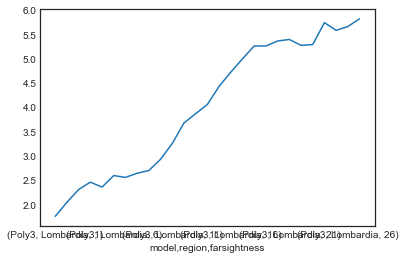

In [147]:
df_results_grouped.mape.plot()